In [1]:
from download_imports_exports import run_weekly_flows_imports
from download_imports_exports import run_weekly_flows_exports, single_request, iso_date, breakdown_payload, download_all_summaries
from download_imports_exports import by_origin_url, by_destination_url, turn_summary_into_rows, iso_date
from download_imports_exports import turn_breakdown_into_rows, download_all_breakdowns, NOW, rolling_week, API_URL, API_KEY
from download_imports_exports import prepare_timeseries_response_for_excel, download_timeseries, api_list_check

/Users/armenazizian/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
import os
import datetime
from datetime import datetime as dt
from datetime import timedelta, tzinfo, time
import pytz
from urllib.request import HTTPError

In [3]:
import dateutil.parser
import numpy as np
import pandas as pd
import requests
import json
from dateutil.relativedelta import relativedelta
from time import sleep

In [4]:
from vortexa_utils.database import RedFactory
from requests.packages.urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter

engine = RedFactory().engine()

In [5]:
from secrets_utils import get_secret_response
secrets = get_secret_response()

In [6]:
# start_of_week = dt.now(pytz.utc) - timedelta(
#     days=dt.today().weekday(),
#     hours=dt.now(pytz.utc).hour,
#     minutes=dt.now(pytz.utc).minute,
#     seconds=dt.now(pytz.utc).second,
#     microseconds=dt.now(pytz.utc).microsecond,
# )
# start_of_week

In [7]:
# dt.now(pytz.utc).microsecond

In [8]:
# def rolling_week(time_period):
#     def gen():
#         min_ts = start_of_week + relativedelta(weeks=time_period)
#         max_ts = min_ts + relativedelta(weeks=1)

#         while int(max_ts.timestamp()) < NOW:
#             yield min_ts, max_ts

#             min_ts = min_ts + relativedelta(weeks=1)
#             max_ts = max_ts + relativedelta(weeks=1)

#     return gen

In [9]:
def run_weekly_flows_imports(destination_ids, product_ids, unit):
    imports = download_all_summaries(
        additional_params={
            "filter_activity": "unloading_start",
            "summary_unit_average_basis": "unloading_start",
            "filter_destinations": destination_ids,
            "filter_products": product_ids,
            "summary_unit": unit,
        },
        time_spans_generator=rolling_week(-52),
    )

    imports_df = pd.DataFrame(turn_summary_into_rows("Imports", imports))
    print("Converted the imports into DF", flush=True)
    
    return imports_df

def run_weekly_flows_exports(origin_id, product_id, unit):
    exports = download_all_summaries(
        additional_params={
            "filter_activity": "loading_end",
            "summary_unit_average_basis": "loading_end",
            "filter_origins": origin_id,
            "filter_products": product_id,
            "summary_unit": unit,
        },
        time_spans_generator=rolling_week(-52),
    )

    exports_df = pd.DataFrame(turn_summary_into_rows("Exports", exports))
    print("Converted the exports into DF", flush=True)

    return exports_df

def run_weekly_flows_imports_crude(list_of_polygons, product_id, unit):
    polygon_ids = list_of_polygons

    result_data_frames = []

    for polygon_id in polygon_ids:
        imports = download_all_breakdowns(
            url=by_origin_url,
            additional_params={
                "filter_activity": "unloading_start",
                "breakdown_unit_average_basis": "unloading_start",
                "breakdown_size": 200,
                "breakdown_unit": unit,
                "breakdown_geography": "region",
                "filter_destinations": [polygon_id],
                "filter_products": [product_id],
#                 "breakdown_product": "subproduct",
            },
            time_spans_generator=rolling_week(-52),
        )

        df = pd.DataFrame(
            turn_breakdown_into_rows(
                "Imports",
                imports,
                lambda ref: {
                    "reporter": ref[polygon_id]["label"],
                    "product": ref[product_id]["label"],
                },
            )
        )

        result_data_frames.append(df)

    return pd.concat(result_data_frames, sort=False, ignore_index=False)

def run_weekly_flows_exports_crude(list_of_polygons, product_id, unit):
    polygon_ids = list_of_polygons

    result_data_frames = []

    for polygon_id in polygon_ids:
        exports = download_all_breakdowns(
            url=by_destination_url,
            additional_params={
                "filter_activity": "loading_end",
                "breakdown_unit_average_basis": "loading_end",
                "breakdown_size": 200,
                "breakdown_unit": unit,
                "breakdown_geography": "region",
                "filter_origins": [polygon_id],
                "filter_products": [product_id],
#                 "breakdown_product": "subproduct",
            },
            time_spans_generator=rolling_week(-52),
        )

        df = pd.DataFrame(
            turn_breakdown_into_rows(
                "Exports",
                exports,
                lambda ref: {
                    "reporter": ref[polygon_id]["label"],
                    "product": ref[product_id]["label"],
                },
            )
        )

        result_data_frames.append(df)

    return pd.concat(result_data_frames, sort=False, ignore_index=False)

def run_weekly_flows_imports_grade(product_id, unit):
    imports = download_all_breakdowns(
        url=by_destination_url,
        additional_params={
            "filter_activity": "unloading_start",
            "breakdown_unit_average_basis": "unloading_start",
            "breakdown_size": 200,
            "breakdown_unit": unit,
            "breakdown_geography": "region",
            "filter_products": [product_id],
#                 "breakdown_product": "subproduct",
        },
        time_spans_generator=rolling_week(-52),
    )

    df = pd.DataFrame(
        turn_breakdown_into_rows(
            "Imports",
            imports,
            lambda ref: {
#                 "reporter": ref[polygon_id]["label"],
                "product": ref[product_id]["label"],
            },
        )
    )


    return df

def excel_prep_ts(gen):
    frame = pd.DataFrame(gen)
    frame.drop(columns=["count"], inplace=True, axis=1)
    frame.rename(columns={"key": "Day", "value": "Quantity"}, inplace=True)
    # frame.set_index(keys="Day", inplace=True)
    return frame

In [10]:
# required regions
padd3_id = ["4e79eb8e84d26f5c3c0006283bc1aa52c170b58d667be9848e136afea91a57e9"]
padd1_id = ["206173974c50fba7fb4476ca5894f7d904283201df993c7dff8d4eb643e1aa8d"]
us_id = ["2d92cc08f22524dba59f6a7e340f132a9da0ce9573cca968eb8e3752ef17a963"]
waf_id = ["5e0cb0b66780a00576309aecff1b65934fc580d775bab29ac2a79397d8544e04"]
batics_id = ["8caa32ab75a70f29578b0f80cb328fbfb0f0e2cf8b79b68e308a66c1ee7707a9"]
russia_id = ["b996521be9c996db3560ca234a56286ac38f798d34be229437555fab4f12a6a5"]
ara_id = ["a50f4a476665d3d507f54398b1a1aed1746c5469619c83c3398716724f8dda27"]
black_sea_id = ["c7ed437dedaec3ea48a0efa5c3c78bd22bc71f9c6f9f44d667801ea633b059f1"]
baltics_black_sea_id = [
    "8caa32ab75a70f29578b0f80cb328fbfb0f0e2cf8b79b68e308a66c1ee7707a9",
    "c7ed437dedaec3ea48a0efa5c3c78bd22bc71f9c6f9f44d667801ea633b059f1",
]
meg_id = ["0899599f74faadb7ba7eb65205ee5c20cb434367a6e7203bc274d310cdb54754"]
india_id = ["70425373a1836d6d0390dc6fef838a468717fba7776d66065a5043488f9f041b"]
sing_id = ["7fed43c640957555ddac588be64822538078409a0acdaf22126623203ef9954a"]

In [11]:
importing_polygons = [
    '2d92cc08f22524dba59f6a7e340f132a9da0ce9573cca968eb8e3752ef17a963',
    '206173974c50fba7fb4476ca5894f7d904283201df993c7dff8d4eb643e1aa8d',
    'c6587383c479b843f2c7e508d83303df17f5f9755504625d2b10323407f70b91',
    '4e79eb8e84d26f5c3c0006283bc1aa52c170b58d667be9848e136afea91a57e9',
    '934c47f36c16a58d68ef5e007e62a23f5f036ee3f3d1f5f85a48c572b90ad8b2',
    '70425373a1836d6d0390dc6fef838a468717fba7776d66065a5043488f9f041b',
]
exporting_polygons = [
    '2d92cc08f22524dba59f6a7e340f132a9da0ce9573cca968eb8e3752ef17a963',
    '4e79eb8e84d26f5c3c0006283bc1aa52c170b58d667be9848e136afea91a57e9',
]
opec =['5057dafe08229da478858da705209d61d88db8dcaadf8376c266eeabdbe1f0ee']

In [12]:
# required products
gasoline_id = ["9256907ba7e4ed11ff03aa297a7e62e14484ce5a85c8118c7495b9120ad0e268"]
naphtha_id = ["3e4db72ef7027de928ce55703a213a546fd86d2debe6f2e9c85f3a5f9d53e8dd"]
gas_nap_id = [
    "9256907ba7e4ed11ff03aa297a7e62e14484ce5a85c8118c7495b9120ad0e268",
    "3e4db72ef7027de928ce55703a213a546fd86d2debe6f2e9c85f3a5f9d53e8dd",
]
lights_id = [
    "9256907ba7e4ed11ff03aa297a7e62e14484ce5a85c8118c7495b9120ad0e268",
    "3e4db72ef7027de928ce55703a213a546fd86d2debe6f2e9c85f3a5f9d53e8dd",
    "d053227a2df2f4d6eacca61341cd6c08e49ba6970cc18a276b898b4bb67eeee4",
]
diesel_gasoil_id = ["deda35eb9ca56b54e74f0ff370423f9a8c61cf6a3796fcb18eaeeb32a8c290bb"]
fuel_oil_id = ["1c107b4317bc2c85fb6c13cd7b28e8e0a02ec7fecc68afc2b68ca0545c835e1c"]
refinery_feedstock_id = [
    "9d4d72cfc5620b4067c22b93e959733d3af66b059767f911efead258e0f7b376"
]
dirty_id = [
    "1c107b4317bc2c85fb6c13cd7b28e8e0a02ec7fecc68afc2b68ca0545c835e1c",
    "9d4d72cfc5620b4067c22b93e959733d3af66b059767f911efead258e0f7b376",
]
distillate_id = [
    "deda35eb9ca56b54e74f0ff370423f9a8c61cf6a3796fcb18eaeeb32a8c290bb",
    "d72edbab2b5e2e249d8c216909945922a02eb017dd200f90876fee6fa180c743",
]
crude_id = "6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653"
heavy_sweet = "3cb81242a4b490d97b78657e8f1d40b994c32d4334051f30369ab18d48b87e4d"
heavy_sour = "fc2e0746428ed6109045fc1195a4ee4ef2e339d55b7b6e3a0fb01ecf28efc4f7"

In [13]:
weekly_summary = os.environ['MARKET_REPORTS_SLACK_HOOK']
# slack_syed = os.environ['SYED_SLACK_HOOK']

In [14]:
def excel_prep(frame, notification_name):
    frame.drop(columns=["flow_type", "source"], inplace=True, axis=1)
    frame.rename(
        columns={"polygon": "country", "period_start": "week_starting"}, inplace=True
    )
    frame["week_starting"] = frame["week_starting"].dt.date
    new_frame = frame.groupby(["week_starting"], as_index=False).sum()
    min_val = new_frame["quantity"].min()
    max_val = new_frame["quantity"].max()
    top_5 = np.quantile(new_frame["quantity"], 0.95)
    bottom_5 = np.quantile(new_frame["quantity"], 0.05)
    new_frame["validation"] = new_frame["quantity"].apply(
        lambda x: "min"
        if x <= min_val
        else "max"
        if x >= max_val
        else ">95"
        if x >= top_5
        else "<5"
        if x <= bottom_5
        else ""
    )
    webhook_url = weekly_summary
    slack_data_unsuccess = {
        "text": f"extreme values produced in last weeks summary data for {notification_name}"
    }
    slack_data_success = {"text": f"table updated ok for {notification_name}"}
    if new_frame['validation'].iloc[-1] != "":
        response = requests.post(
            webhook_url,
            data=json.dumps(slack_data_unsuccess),
            headers={"Content-Type": "application/json"},
        )
        print("analysts notified")
    else:
        # response = requests.post(
        #     webhook_url,
        #     data=json.dumps(slack_data_success),
        #     headers={"Content-Type": "application/json"},
        # )
        print("table ok")
    # frame.set_index(keys="week_starting", inplace=True)
    return new_frame

### Products report

In [15]:
padd_1_lights_imports = excel_prep(run_weekly_flows_imports(padd1_id, lights_id, "t"), "PADD 1 gasoline imports")

Getting breakdown for month 2019-10-28 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-10-28T00:00:00.999Z', 'filter_time_max': '2019-11-04T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['206173974c50fba7fb4476ca5894f7d904283201df993c7dff8d4eb643e1aa8d'], 'filter_products': ['9256907ba7e4ed11ff03aa297a7e62e14484ce5a85c8118c7495b9120ad0e268', '3e4db72ef7027de928ce55703a213a546fd86d2debe6f2e9c85f3a5f9d53e8dd', 'd053227a2df2f4d6eacca61341cd6c08e49ba6970cc18a276b898b4bb67eeee4']}
Request sent
Response decoded
Getting breakdown for month 2019-11-04 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-11-04T00:00:00.999Z', 'filter_time_max': '2019-11-11T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_ru

Request sent
Response decoded
Getting breakdown for month 2020-01-20 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-01-20T00:00:00.999Z', 'filter_time_max': '2020-01-27T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['206173974c50fba7fb4476ca5894f7d904283201df993c7dff8d4eb643e1aa8d'], 'filter_products': ['9256907ba7e4ed11ff03aa297a7e62e14484ce5a85c8118c7495b9120ad0e268', '3e4db72ef7027de928ce55703a213a546fd86d2debe6f2e9c85f3a5f9d53e8dd', 'd053227a2df2f4d6eacca61341cd6c08e49ba6970cc18a276b898b4bb67eeee4']}
Request sent
Response decoded
Getting breakdown for month 2020-01-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-01-27T00:00:00.999Z', 'filter_time_max': '2020-02-03T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'd

Request sent
Response decoded
Getting breakdown for month 2020-04-13 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-04-13T00:00:00.999Z', 'filter_time_max': '2020-04-20T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['206173974c50fba7fb4476ca5894f7d904283201df993c7dff8d4eb643e1aa8d'], 'filter_products': ['9256907ba7e4ed11ff03aa297a7e62e14484ce5a85c8118c7495b9120ad0e268', '3e4db72ef7027de928ce55703a213a546fd86d2debe6f2e9c85f3a5f9d53e8dd', 'd053227a2df2f4d6eacca61341cd6c08e49ba6970cc18a276b898b4bb67eeee4']}
Request sent
Response decoded
Getting breakdown for month 2020-04-20 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-04-20T00:00:00.999Z', 'filter_time_max': '2020-04-27T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'd

Request sent
Response decoded
Getting breakdown for month 2020-07-06 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-07-06T00:00:00.999Z', 'filter_time_max': '2020-07-13T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['206173974c50fba7fb4476ca5894f7d904283201df993c7dff8d4eb643e1aa8d'], 'filter_products': ['9256907ba7e4ed11ff03aa297a7e62e14484ce5a85c8118c7495b9120ad0e268', '3e4db72ef7027de928ce55703a213a546fd86d2debe6f2e9c85f3a5f9d53e8dd', 'd053227a2df2f4d6eacca61341cd6c08e49ba6970cc18a276b898b4bb67eeee4']}
Request sent
Response decoded
Getting breakdown for month 2020-07-13 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-07-13T00:00:00.999Z', 'filter_time_max': '2020-07-20T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'd

Request sent
Response decoded
Getting breakdown for month 2020-09-28 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-09-28T00:00:00.999Z', 'filter_time_max': '2020-10-05T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['206173974c50fba7fb4476ca5894f7d904283201df993c7dff8d4eb643e1aa8d'], 'filter_products': ['9256907ba7e4ed11ff03aa297a7e62e14484ce5a85c8118c7495b9120ad0e268', '3e4db72ef7027de928ce55703a213a546fd86d2debe6f2e9c85f3a5f9d53e8dd', 'd053227a2df2f4d6eacca61341cd6c08e49ba6970cc18a276b898b4bb67eeee4']}
Request sent
Response decoded
Getting breakdown for month 2020-10-05 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-10-05T00:00:00.999Z', 'filter_time_max': '2020-10-12T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'd

In [16]:
padd_1_lights_imports = excel_prep(run_weekly_flows_imports(padd1_id, lights_id, "t"), "PADD 1 gasoline imports")
waf_gasoline_imports = excel_prep(run_weekly_flows_imports(waf_id, gasoline_id, "t"), "WAF gasoline imports")
meg_naphtha_exports = excel_prep(run_weekly_flows_exports(meg_id, naphtha_id, "t"), "ME gulf naphtha exports")
russia_naphtha_exports = excel_prep(run_weekly_flows_exports(russia_id, naphtha_id, "t"), "Russia naphtha exports")

ara_dist_imports = excel_prep(run_weekly_flows_imports(ara_id, diesel_gasoil_id, "t"), "ARA diesel imports")
padd3_dist_exports = excel_prep(run_weekly_flows_exports(padd3_id, diesel_gasoil_id, "t"), "PADD 3 diesel exports")
baltic_dist_exports = excel_prep(run_weekly_flows_exports(batics_id, diesel_gasoil_id, "t"), "Baltic diesel exports")
india_dist_exports = excel_prep(run_weekly_flows_exports(india_id, diesel_gasoil_id, "t"), "India diesel exports")

baltic_black_sea_fo_exports = excel_prep(run_weekly_flows_exports(baltics_black_sea_id, fuel_oil_id, "t"), "FSU FO exports")
baltic_black_sea_feedstock_exports = excel_prep(run_weekly_flows_exports(baltics_black_sea_id, dirty_id, "t"), "FSU VGO/FO exports")
sing_fo_imports = excel_prep(run_weekly_flows_imports(sing_id, fuel_oil_id, "t"), "Singapore FO imports")
us_feedstock_imports = excel_prep(run_weekly_flows_imports(us_id, refinery_feedstock_id, "t"), "US VGO imports")

Getting breakdown for month 2019-10-28 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-10-28T00:00:00.999Z', 'filter_time_max': '2019-11-04T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['206173974c50fba7fb4476ca5894f7d904283201df993c7dff8d4eb643e1aa8d'], 'filter_products': ['9256907ba7e4ed11ff03aa297a7e62e14484ce5a85c8118c7495b9120ad0e268', '3e4db72ef7027de928ce55703a213a546fd86d2debe6f2e9c85f3a5f9d53e8dd', 'd053227a2df2f4d6eacca61341cd6c08e49ba6970cc18a276b898b4bb67eeee4']}
Request sent
Response decoded
Getting breakdown for month 2019-11-04 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-11-04T00:00:00.999Z', 'filter_time_max': '2019-11-11T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_ru

Request sent
Response decoded
Getting breakdown for month 2020-01-20 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-01-20T00:00:00.999Z', 'filter_time_max': '2020-01-27T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['206173974c50fba7fb4476ca5894f7d904283201df993c7dff8d4eb643e1aa8d'], 'filter_products': ['9256907ba7e4ed11ff03aa297a7e62e14484ce5a85c8118c7495b9120ad0e268', '3e4db72ef7027de928ce55703a213a546fd86d2debe6f2e9c85f3a5f9d53e8dd', 'd053227a2df2f4d6eacca61341cd6c08e49ba6970cc18a276b898b4bb67eeee4']}
Request sent
Response decoded
Getting breakdown for month 2020-01-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-01-27T00:00:00.999Z', 'filter_time_max': '2020-02-03T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'd

Request sent
Response decoded
Getting breakdown for month 2020-04-13 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-04-13T00:00:00.999Z', 'filter_time_max': '2020-04-20T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['206173974c50fba7fb4476ca5894f7d904283201df993c7dff8d4eb643e1aa8d'], 'filter_products': ['9256907ba7e4ed11ff03aa297a7e62e14484ce5a85c8118c7495b9120ad0e268', '3e4db72ef7027de928ce55703a213a546fd86d2debe6f2e9c85f3a5f9d53e8dd', 'd053227a2df2f4d6eacca61341cd6c08e49ba6970cc18a276b898b4bb67eeee4']}
Request sent
Response decoded
Getting breakdown for month 2020-04-20 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-04-20T00:00:00.999Z', 'filter_time_max': '2020-04-27T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'd

Request sent
Response decoded
Getting breakdown for month 2020-07-06 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-07-06T00:00:00.999Z', 'filter_time_max': '2020-07-13T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['206173974c50fba7fb4476ca5894f7d904283201df993c7dff8d4eb643e1aa8d'], 'filter_products': ['9256907ba7e4ed11ff03aa297a7e62e14484ce5a85c8118c7495b9120ad0e268', '3e4db72ef7027de928ce55703a213a546fd86d2debe6f2e9c85f3a5f9d53e8dd', 'd053227a2df2f4d6eacca61341cd6c08e49ba6970cc18a276b898b4bb67eeee4']}
Request sent
Response decoded
Getting breakdown for month 2020-07-13 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-07-13T00:00:00.999Z', 'filter_time_max': '2020-07-20T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'd

Request sent
Response decoded
Getting breakdown for month 2020-09-28 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-09-28T00:00:00.999Z', 'filter_time_max': '2020-10-05T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['206173974c50fba7fb4476ca5894f7d904283201df993c7dff8d4eb643e1aa8d'], 'filter_products': ['9256907ba7e4ed11ff03aa297a7e62e14484ce5a85c8118c7495b9120ad0e268', '3e4db72ef7027de928ce55703a213a546fd86d2debe6f2e9c85f3a5f9d53e8dd', 'd053227a2df2f4d6eacca61341cd6c08e49ba6970cc18a276b898b4bb67eeee4']}
Request sent
Response decoded
Getting breakdown for month 2020-10-05 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-10-05T00:00:00.999Z', 'filter_time_max': '2020-10-12T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'd

Request sent
Response decoded
Getting breakdown for month 2019-12-30 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-12-30T00:00:00.999Z', 'filter_time_max': '2020-01-06T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['5e0cb0b66780a00576309aecff1b65934fc580d775bab29ac2a79397d8544e04'], 'filter_products': ['9256907ba7e4ed11ff03aa297a7e62e14484ce5a85c8118c7495b9120ad0e268']}
Request sent
Response decoded
Getting breakdown for month 2020-01-06 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-01-06T00:00:00.999Z', 'filter_time_max': '2020-01-13T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filte

Request sent
Response decoded
Getting breakdown for month 2020-04-06 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-04-06T00:00:00.999Z', 'filter_time_max': '2020-04-13T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['5e0cb0b66780a00576309aecff1b65934fc580d775bab29ac2a79397d8544e04'], 'filter_products': ['9256907ba7e4ed11ff03aa297a7e62e14484ce5a85c8118c7495b9120ad0e268']}
Request sent
Response decoded
Getting breakdown for month 2020-04-13 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-04-13T00:00:00.999Z', 'filter_time_max': '2020-04-20T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filte

Request sent
Response decoded
Getting breakdown for month 2020-07-13 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-07-13T00:00:00.999Z', 'filter_time_max': '2020-07-20T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['5e0cb0b66780a00576309aecff1b65934fc580d775bab29ac2a79397d8544e04'], 'filter_products': ['9256907ba7e4ed11ff03aa297a7e62e14484ce5a85c8118c7495b9120ad0e268']}
Request sent
Response decoded
Getting breakdown for month 2020-07-20 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-07-20T00:00:00.999Z', 'filter_time_max': '2020-07-27T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filte

Request sent
Response decoded
Getting breakdown for month 2020-10-19 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-10-19T00:00:00.999Z', 'filter_time_max': '2020-10-26T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['5e0cb0b66780a00576309aecff1b65934fc580d775bab29ac2a79397d8544e04'], 'filter_products': ['9256907ba7e4ed11ff03aa297a7e62e14484ce5a85c8118c7495b9120ad0e268']}
Request sent
Response decoded
Converted the imports into DF
table ok
Getting breakdown for month 2019-10-28 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-10-28T00:00:00.999Z', 'filter_time_max': '2019-11-04T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_averag

Request sent
Response decoded
Getting breakdown for month 2020-02-03 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-02-03T00:00:00.999Z', 'filter_time_max': '2020-02-10T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['0899599f74faadb7ba7eb65205ee5c20cb434367a6e7203bc274d310cdb54754'], 'filter_products': ['3e4db72ef7027de928ce55703a213a546fd86d2debe6f2e9c85f3a5f9d53e8dd']}
Request sent
Response decoded
Getting breakdown for month 2020-02-10 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-02-10T00:00:00.999Z', 'filter_time_max': '2020-02-17T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['0899599

Request sent
Response decoded
Getting breakdown for month 2020-05-18 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-05-18T00:00:00.999Z', 'filter_time_max': '2020-05-25T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['0899599f74faadb7ba7eb65205ee5c20cb434367a6e7203bc274d310cdb54754'], 'filter_products': ['3e4db72ef7027de928ce55703a213a546fd86d2debe6f2e9c85f3a5f9d53e8dd']}
Request sent
Response decoded
Getting breakdown for month 2020-05-25 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-05-25T00:00:00.999Z', 'filter_time_max': '2020-06-01T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['0899599

Request sent
Response decoded
Getting breakdown for month 2020-08-31 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-08-31T00:00:00.999Z', 'filter_time_max': '2020-09-07T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['0899599f74faadb7ba7eb65205ee5c20cb434367a6e7203bc274d310cdb54754'], 'filter_products': ['3e4db72ef7027de928ce55703a213a546fd86d2debe6f2e9c85f3a5f9d53e8dd']}
Request sent
Response decoded
Getting breakdown for month 2020-09-07 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-09-07T00:00:00.999Z', 'filter_time_max': '2020-09-14T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['0899599

Request sent
Response decoded
Getting breakdown for month 2019-12-16 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-12-16T00:00:00.999Z', 'filter_time_max': '2019-12-23T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['b996521be9c996db3560ca234a56286ac38f798d34be229437555fab4f12a6a5'], 'filter_products': ['3e4db72ef7027de928ce55703a213a546fd86d2debe6f2e9c85f3a5f9d53e8dd']}
Request sent
Response decoded
Getting breakdown for month 2019-12-23 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-12-23T00:00:00.999Z', 'filter_time_max': '2019-12-30T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['b996521

Request sent
Response decoded
Getting breakdown for month 2020-03-30 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-03-30T00:00:00.999Z', 'filter_time_max': '2020-04-06T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['b996521be9c996db3560ca234a56286ac38f798d34be229437555fab4f12a6a5'], 'filter_products': ['3e4db72ef7027de928ce55703a213a546fd86d2debe6f2e9c85f3a5f9d53e8dd']}
Request sent
Response decoded
Getting breakdown for month 2020-04-06 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-04-06T00:00:00.999Z', 'filter_time_max': '2020-04-13T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['b996521

Request sent
Response decoded
Getting breakdown for month 2020-07-13 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-07-13T00:00:00.999Z', 'filter_time_max': '2020-07-20T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['b996521be9c996db3560ca234a56286ac38f798d34be229437555fab4f12a6a5'], 'filter_products': ['3e4db72ef7027de928ce55703a213a546fd86d2debe6f2e9c85f3a5f9d53e8dd']}
Request sent
Response decoded
Getting breakdown for month 2020-07-20 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-07-20T00:00:00.999Z', 'filter_time_max': '2020-07-27T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['b996521

Request sent
Response decoded
Converted the exports into DF
table ok
Getting breakdown for month 2019-10-28 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-10-28T00:00:00.999Z', 'filter_time_max': '2019-11-04T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['a50f4a476665d3d507f54398b1a1aed1746c5469619c83c3398716724f8dda27'], 'filter_products': ['deda35eb9ca56b54e74f0ff370423f9a8c61cf6a3796fcb18eaeeb32a8c290bb']}
Request sent
Response decoded
Getting breakdown for month 2019-11-04 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-11-04T00:00:00.999Z', 'filter_time_max': '2019-11-11T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_av

Request sent
Response decoded
Getting breakdown for month 2020-02-03 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-02-03T00:00:00.999Z', 'filter_time_max': '2020-02-10T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['a50f4a476665d3d507f54398b1a1aed1746c5469619c83c3398716724f8dda27'], 'filter_products': ['deda35eb9ca56b54e74f0ff370423f9a8c61cf6a3796fcb18eaeeb32a8c290bb']}
Request sent
Response decoded
Getting breakdown for month 2020-02-10 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-02-10T00:00:00.999Z', 'filter_time_max': '2020-02-17T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filte

Request sent
Response decoded
Getting breakdown for month 2020-05-11 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-05-11T00:00:00.999Z', 'filter_time_max': '2020-05-18T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['a50f4a476665d3d507f54398b1a1aed1746c5469619c83c3398716724f8dda27'], 'filter_products': ['deda35eb9ca56b54e74f0ff370423f9a8c61cf6a3796fcb18eaeeb32a8c290bb']}
Request sent
Response decoded
Getting breakdown for month 2020-05-18 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-05-18T00:00:00.999Z', 'filter_time_max': '2020-05-25T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filte

Request sent
Response decoded
Getting breakdown for month 2020-08-17 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-08-17T00:00:00.999Z', 'filter_time_max': '2020-08-24T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['a50f4a476665d3d507f54398b1a1aed1746c5469619c83c3398716724f8dda27'], 'filter_products': ['deda35eb9ca56b54e74f0ff370423f9a8c61cf6a3796fcb18eaeeb32a8c290bb']}
Request sent
Response decoded
Getting breakdown for month 2020-08-24 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-08-24T00:00:00.999Z', 'filter_time_max': '2020-08-31T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filte

Request sent
Response decoded
Getting breakdown for month 2019-11-25 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-11-25T00:00:00.999Z', 'filter_time_max': '2019-12-02T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['4e79eb8e84d26f5c3c0006283bc1aa52c170b58d667be9848e136afea91a57e9'], 'filter_products': ['deda35eb9ca56b54e74f0ff370423f9a8c61cf6a3796fcb18eaeeb32a8c290bb']}
Request sent
Response decoded
Getting breakdown for month 2019-12-02 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-12-02T00:00:00.999Z', 'filter_time_max': '2019-12-09T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['4e79eb8

Request sent
Response decoded
Getting breakdown for month 2020-03-09 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-03-09T00:00:00.999Z', 'filter_time_max': '2020-03-16T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['4e79eb8e84d26f5c3c0006283bc1aa52c170b58d667be9848e136afea91a57e9'], 'filter_products': ['deda35eb9ca56b54e74f0ff370423f9a8c61cf6a3796fcb18eaeeb32a8c290bb']}
Request sent
Response decoded
Getting breakdown for month 2020-03-16 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-03-16T00:00:00.999Z', 'filter_time_max': '2020-03-23T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['4e79eb8

Request sent
Response decoded
Getting breakdown for month 2020-06-22 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-06-22T00:00:00.999Z', 'filter_time_max': '2020-06-29T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['4e79eb8e84d26f5c3c0006283bc1aa52c170b58d667be9848e136afea91a57e9'], 'filter_products': ['deda35eb9ca56b54e74f0ff370423f9a8c61cf6a3796fcb18eaeeb32a8c290bb']}
Request sent
Response decoded
Getting breakdown for month 2020-06-29 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-06-29T00:00:00.999Z', 'filter_time_max': '2020-07-06T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['4e79eb8

Request sent
Response decoded
Getting breakdown for month 2020-10-05 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-10-05T00:00:00.999Z', 'filter_time_max': '2020-10-12T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['4e79eb8e84d26f5c3c0006283bc1aa52c170b58d667be9848e136afea91a57e9'], 'filter_products': ['deda35eb9ca56b54e74f0ff370423f9a8c61cf6a3796fcb18eaeeb32a8c290bb']}
Request sent
Response decoded
Getting breakdown for month 2020-10-12 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-10-12T00:00:00.999Z', 'filter_time_max': '2020-10-19T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['4e79eb8

Request sent
Response decoded
Getting breakdown for month 2020-01-20 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-01-20T00:00:00.999Z', 'filter_time_max': '2020-01-27T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['8caa32ab75a70f29578b0f80cb328fbfb0f0e2cf8b79b68e308a66c1ee7707a9'], 'filter_products': ['deda35eb9ca56b54e74f0ff370423f9a8c61cf6a3796fcb18eaeeb32a8c290bb']}
Request sent
Response decoded
Getting breakdown for month 2020-01-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-01-27T00:00:00.999Z', 'filter_time_max': '2020-02-03T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['8caa32a

Request sent
Response decoded
Getting breakdown for month 2020-05-04 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-05-04T00:00:00.999Z', 'filter_time_max': '2020-05-11T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['8caa32ab75a70f29578b0f80cb328fbfb0f0e2cf8b79b68e308a66c1ee7707a9'], 'filter_products': ['deda35eb9ca56b54e74f0ff370423f9a8c61cf6a3796fcb18eaeeb32a8c290bb']}
Request sent
Response decoded
Getting breakdown for month 2020-05-11 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-05-11T00:00:00.999Z', 'filter_time_max': '2020-05-18T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['8caa32a

Request sent
Response decoded
Getting breakdown for month 2020-08-17 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-08-17T00:00:00.999Z', 'filter_time_max': '2020-08-24T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['8caa32ab75a70f29578b0f80cb328fbfb0f0e2cf8b79b68e308a66c1ee7707a9'], 'filter_products': ['deda35eb9ca56b54e74f0ff370423f9a8c61cf6a3796fcb18eaeeb32a8c290bb']}
Request sent
Response decoded
Getting breakdown for month 2020-08-24 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-08-24T00:00:00.999Z', 'filter_time_max': '2020-08-31T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['8caa32a

Request sent
Response decoded
Getting breakdown for month 2019-12-02 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-12-02T00:00:00.999Z', 'filter_time_max': '2019-12-09T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['70425373a1836d6d0390dc6fef838a468717fba7776d66065a5043488f9f041b'], 'filter_products': ['deda35eb9ca56b54e74f0ff370423f9a8c61cf6a3796fcb18eaeeb32a8c290bb']}
Request sent
Response decoded
Getting breakdown for month 2019-12-09 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-12-09T00:00:00.999Z', 'filter_time_max': '2019-12-16T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['7042537

Request sent
Response decoded
Getting breakdown for month 2020-03-16 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-03-16T00:00:00.999Z', 'filter_time_max': '2020-03-23T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['70425373a1836d6d0390dc6fef838a468717fba7776d66065a5043488f9f041b'], 'filter_products': ['deda35eb9ca56b54e74f0ff370423f9a8c61cf6a3796fcb18eaeeb32a8c290bb']}
Request sent
Response decoded
Getting breakdown for month 2020-03-23 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-03-23T00:00:00.999Z', 'filter_time_max': '2020-03-30T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['7042537

Request sent
Response decoded
Getting breakdown for month 2020-06-29 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-06-29T00:00:00.999Z', 'filter_time_max': '2020-07-06T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['70425373a1836d6d0390dc6fef838a468717fba7776d66065a5043488f9f041b'], 'filter_products': ['deda35eb9ca56b54e74f0ff370423f9a8c61cf6a3796fcb18eaeeb32a8c290bb']}
Request sent
Response decoded
Getting breakdown for month 2020-07-06 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-07-06T00:00:00.999Z', 'filter_time_max': '2020-07-13T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['7042537

Request sent
Response decoded
Getting breakdown for month 2020-10-12 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-10-12T00:00:00.999Z', 'filter_time_max': '2020-10-19T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['70425373a1836d6d0390dc6fef838a468717fba7776d66065a5043488f9f041b'], 'filter_products': ['deda35eb9ca56b54e74f0ff370423f9a8c61cf6a3796fcb18eaeeb32a8c290bb']}
Request sent
Response decoded
Getting breakdown for month 2020-10-19 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-10-19T00:00:00.999Z', 'filter_time_max': '2020-10-26T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['7042537

Request sent
Response decoded
Getting breakdown for month 2020-01-13 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-01-13T00:00:00.999Z', 'filter_time_max': '2020-01-20T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['8caa32ab75a70f29578b0f80cb328fbfb0f0e2cf8b79b68e308a66c1ee7707a9', 'c7ed437dedaec3ea48a0efa5c3c78bd22bc71f9c6f9f44d667801ea633b059f1'], 'filter_products': ['1c107b4317bc2c85fb6c13cd7b28e8e0a02ec7fecc68afc2b68ca0545c835e1c']}
Request sent
Response decoded
Getting breakdown for month 2020-01-20 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-01-20T00:00:00.999Z', 'filter_time_max': '2020-01-27T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'sum

Request sent
Response decoded
Getting breakdown for month 2020-04-13 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-04-13T00:00:00.999Z', 'filter_time_max': '2020-04-20T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['8caa32ab75a70f29578b0f80cb328fbfb0f0e2cf8b79b68e308a66c1ee7707a9', 'c7ed437dedaec3ea48a0efa5c3c78bd22bc71f9c6f9f44d667801ea633b059f1'], 'filter_products': ['1c107b4317bc2c85fb6c13cd7b28e8e0a02ec7fecc68afc2b68ca0545c835e1c']}
Request sent
Response decoded
Getting breakdown for month 2020-04-20 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-04-20T00:00:00.999Z', 'filter_time_max': '2020-04-27T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'sum

Request sent
Response decoded
Getting breakdown for month 2020-07-13 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-07-13T00:00:00.999Z', 'filter_time_max': '2020-07-20T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['8caa32ab75a70f29578b0f80cb328fbfb0f0e2cf8b79b68e308a66c1ee7707a9', 'c7ed437dedaec3ea48a0efa5c3c78bd22bc71f9c6f9f44d667801ea633b059f1'], 'filter_products': ['1c107b4317bc2c85fb6c13cd7b28e8e0a02ec7fecc68afc2b68ca0545c835e1c']}
Request sent
Response decoded
Getting breakdown for month 2020-07-20 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-07-20T00:00:00.999Z', 'filter_time_max': '2020-07-27T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'sum

Request sent
Response decoded
Getting breakdown for month 2020-10-12 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-10-12T00:00:00.999Z', 'filter_time_max': '2020-10-19T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['8caa32ab75a70f29578b0f80cb328fbfb0f0e2cf8b79b68e308a66c1ee7707a9', 'c7ed437dedaec3ea48a0efa5c3c78bd22bc71f9c6f9f44d667801ea633b059f1'], 'filter_products': ['1c107b4317bc2c85fb6c13cd7b28e8e0a02ec7fecc68afc2b68ca0545c835e1c']}
Request sent
Response decoded
Getting breakdown for month 2020-10-19 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-10-19T00:00:00.999Z', 'filter_time_max': '2020-10-26T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'sum

Request sent
Response decoded
Getting breakdown for month 2020-01-06 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-01-06T00:00:00.999Z', 'filter_time_max': '2020-01-13T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['8caa32ab75a70f29578b0f80cb328fbfb0f0e2cf8b79b68e308a66c1ee7707a9', 'c7ed437dedaec3ea48a0efa5c3c78bd22bc71f9c6f9f44d667801ea633b059f1'], 'filter_products': ['1c107b4317bc2c85fb6c13cd7b28e8e0a02ec7fecc68afc2b68ca0545c835e1c', '9d4d72cfc5620b4067c22b93e959733d3af66b059767f911efead258e0f7b376']}
Request sent
Response decoded
Getting breakdown for month 2020-01-13 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-01-13T00:00:00.999Z', 'filter_time_max': '2020-01-20T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geogra

Request sent
Response decoded
Getting breakdown for month 2020-03-30 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-03-30T00:00:00.999Z', 'filter_time_max': '2020-04-06T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['8caa32ab75a70f29578b0f80cb328fbfb0f0e2cf8b79b68e308a66c1ee7707a9', 'c7ed437dedaec3ea48a0efa5c3c78bd22bc71f9c6f9f44d667801ea633b059f1'], 'filter_products': ['1c107b4317bc2c85fb6c13cd7b28e8e0a02ec7fecc68afc2b68ca0545c835e1c', '9d4d72cfc5620b4067c22b93e959733d3af66b059767f911efead258e0f7b376']}
Request sent
Response decoded
Getting breakdown for month 2020-04-06 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-04-06T00:00:00.999Z', 'filter_time_max': '2020-04-13T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geogra

Request sent
Response decoded
Getting breakdown for month 2020-06-22 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-06-22T00:00:00.999Z', 'filter_time_max': '2020-06-29T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['8caa32ab75a70f29578b0f80cb328fbfb0f0e2cf8b79b68e308a66c1ee7707a9', 'c7ed437dedaec3ea48a0efa5c3c78bd22bc71f9c6f9f44d667801ea633b059f1'], 'filter_products': ['1c107b4317bc2c85fb6c13cd7b28e8e0a02ec7fecc68afc2b68ca0545c835e1c', '9d4d72cfc5620b4067c22b93e959733d3af66b059767f911efead258e0f7b376']}
Request sent
Response decoded
Getting breakdown for month 2020-06-29 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-06-29T00:00:00.999Z', 'filter_time_max': '2020-07-06T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geogra

Request sent
Response decoded
Getting breakdown for month 2020-09-14 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-09-14T00:00:00.999Z', 'filter_time_max': '2020-09-21T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'summary_unit_average_basis': 'loading_end', 'filter_origins': ['8caa32ab75a70f29578b0f80cb328fbfb0f0e2cf8b79b68e308a66c1ee7707a9', 'c7ed437dedaec3ea48a0efa5c3c78bd22bc71f9c6f9f44d667801ea633b059f1'], 'filter_products': ['1c107b4317bc2c85fb6c13cd7b28e8e0a02ec7fecc68afc2b68ca0545c835e1c', '9d4d72cfc5620b4067c22b93e959733d3af66b059767f911efead258e0f7b376']}
Request sent
Response decoded
Getting breakdown for month 2020-09-21 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-09-21T00:00:00.999Z', 'filter_time_max': '2020-09-28T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geogra

Request sent
Response decoded
Getting breakdown for month 2019-12-16 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-12-16T00:00:00.999Z', 'filter_time_max': '2019-12-23T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['7fed43c640957555ddac588be64822538078409a0acdaf22126623203ef9954a'], 'filter_products': ['1c107b4317bc2c85fb6c13cd7b28e8e0a02ec7fecc68afc2b68ca0545c835e1c']}
Request sent
Response decoded
Getting breakdown for month 2019-12-23 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-12-23T00:00:00.999Z', 'filter_time_max': '2019-12-30T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filte

Request sent
Response decoded
Getting breakdown for month 2020-03-23 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-03-23T00:00:00.999Z', 'filter_time_max': '2020-03-30T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['7fed43c640957555ddac588be64822538078409a0acdaf22126623203ef9954a'], 'filter_products': ['1c107b4317bc2c85fb6c13cd7b28e8e0a02ec7fecc68afc2b68ca0545c835e1c']}
Request sent
Response decoded
Getting breakdown for month 2020-03-30 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-03-30T00:00:00.999Z', 'filter_time_max': '2020-04-06T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filte

Request sent
Response decoded
Getting breakdown for month 2020-06-29 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-06-29T00:00:00.999Z', 'filter_time_max': '2020-07-06T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['7fed43c640957555ddac588be64822538078409a0acdaf22126623203ef9954a'], 'filter_products': ['1c107b4317bc2c85fb6c13cd7b28e8e0a02ec7fecc68afc2b68ca0545c835e1c']}
Request sent
Response decoded
Getting breakdown for month 2020-07-06 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-07-06T00:00:00.999Z', 'filter_time_max': '2020-07-13T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filte

Request sent
Response decoded
Getting breakdown for month 2020-10-05 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-10-05T00:00:00.999Z', 'filter_time_max': '2020-10-12T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['7fed43c640957555ddac588be64822538078409a0acdaf22126623203ef9954a'], 'filter_products': ['1c107b4317bc2c85fb6c13cd7b28e8e0a02ec7fecc68afc2b68ca0545c835e1c']}
Request sent
Response decoded
Getting breakdown for month 2020-10-12 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-10-12T00:00:00.999Z', 'filter_time_max': '2020-10-19T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filte

Request sent
Response decoded
Getting breakdown for month 2020-01-13 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-01-13T00:00:00.999Z', 'filter_time_max': '2020-01-20T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['2d92cc08f22524dba59f6a7e340f132a9da0ce9573cca968eb8e3752ef17a963'], 'filter_products': ['9d4d72cfc5620b4067c22b93e959733d3af66b059767f911efead258e0f7b376']}
Request sent
Response decoded
Getting breakdown for month 2020-01-20 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-01-20T00:00:00.999Z', 'filter_time_max': '2020-01-27T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filte

Request sent
Response decoded
Getting breakdown for month 2020-04-20 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-04-20T00:00:00.999Z', 'filter_time_max': '2020-04-27T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['2d92cc08f22524dba59f6a7e340f132a9da0ce9573cca968eb8e3752ef17a963'], 'filter_products': ['9d4d72cfc5620b4067c22b93e959733d3af66b059767f911efead258e0f7b376']}
Request sent
Response decoded
Getting breakdown for month 2020-04-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-04-27T00:00:00.999Z', 'filter_time_max': '2020-05-04T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filte

Request sent
Response decoded
Getting breakdown for month 2020-07-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-07-27T00:00:00.999Z', 'filter_time_max': '2020-08-03T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filter_destinations': ['2d92cc08f22524dba59f6a7e340f132a9da0ce9573cca968eb8e3752ef17a963'], 'filter_products': ['9d4d72cfc5620b4067c22b93e959733d3af66b059767f911efead258e0f7b376']}
Request sent
Response decoded
Getting breakdown for month 2020-08-03 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-08-03T00:00:00.999Z', 'filter_time_max': '2020-08-10T00:00:00.999Z', 'filter_confidence': 'low', 'summary_unit': 't', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'summary_unit_average_basis': 'unloading_start', 'filte

In [17]:
API_URL = secrets["API_URL"]
API_KEY = secrets["API_KEY"]
#### start_ts = "2019-01-01T00:00:00.000Z"
#### end_ts = "2019-04-04T23:59:59.999Z"
now_ts = datetime.datetime.now()
start_ts = now_ts + datetime.timedelta(days=-92)


# def download_timeseries(additional_params):
#     return single_request(
#         f"{API_URL}/time-series?apikey={API_KEY}",
#         {
#             "filter_activity": "any_activity",
#             "filter_confidence": "low",
#             "disable_geographic_exclusion_rules": True,
#             **additional_params,
#         },
#     )


# def prepare_timeseries_response_for_excel(response):
#     for datum in response["data"]:
#         yield {**datum, "key": pd.to_datetime(datum["key"])}


# def excel_prep_ts(frame):
#     frame.drop(columns=["count"], inplace=True, axis=1)
#     frame.rename(columns={"key": "Day", "value": "Quantity"}, inplace=True)
#     # frame.set_index(keys="Day", inplace=True)
#     return frame

In [18]:
timeseries_dist = download_timeseries(
    {
        "filter_products": distillate_id,
        "filter_time_min": iso_date(start_ts),
        "filter_time_max": iso_date(now_ts),
        "timeseries_activity": "transiting_state",
        "timeseries_frequency": "day",
        "timeseries_unit": "t",
    }
)

dist_otw = excel_prep_ts(
    pd.DataFrame(prepare_timeseries_response_for_excel(timeseries_dist))
)
dist_otw.drop(['breakdown'], axis='columns', inplace=True)

Request sent
Response decoded


In [19]:
timeseries_lights = download_timeseries(
    {
        "filter_products": gas_nap_id,
        "filter_time_min": iso_date(start_ts),
        "filter_time_max": iso_date(now_ts),
        "timeseries_activity": "transiting_state",
        "timeseries_frequency": "day",
        "timeseries_unit": "t",
    }
)
lights_otw = excel_prep_ts(
    pd.DataFrame(prepare_timeseries_response_for_excel(timeseries_lights))
)
lights_otw.drop(['breakdown'], axis='columns', inplace=True)

Request sent
Response decoded


In [20]:
timeseries_dirty = download_timeseries(
    {
        "filter_products": dirty_id,
        "filter_time_min": iso_date(start_ts),
        "filter_time_max": iso_date(now_ts),
        "timeseries_activity": "transiting_state",
        "timeseries_frequency": "day",
        "timeseries_unit": "t",
    }
)

dirty_otw = excel_prep_ts(
    pd.DataFrame(prepare_timeseries_response_for_excel(timeseries_dirty))
)
dirty_otw.drop(['breakdown'], axis='columns', inplace=True)

Request sent
Response decoded


### Crude report

In [21]:
import_flows = run_weekly_flows_imports_crude(list_of_polygons=importing_polygons, product_id=crude_id, unit='b')

Getting breakdown for month 2019-10-28 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-10-28T00:00:00.999Z', 'filter_time_max': '2019-11-04T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_destinations': ['2d92cc08f22524dba59f6a7e340f132a9da0ce9573cca968eb8e3752ef17a963'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2019-11-04 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-11-04T00:00:00.999Z', 'filter_time_max': '2019-11-11T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filt

Request sent
Response decoded
Getting breakdown for month 2020-01-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-01-27T00:00:00.999Z', 'filter_time_max': '2020-02-03T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_destinations': ['2d92cc08f22524dba59f6a7e340f132a9da0ce9573cca968eb8e3752ef17a963'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-02-03 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-02-03T00:00:00.999Z', 'filter_time_max': '2020-02-10T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_

Request sent
Response decoded
Getting breakdown for month 2020-04-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-04-27T00:00:00.999Z', 'filter_time_max': '2020-05-04T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_destinations': ['2d92cc08f22524dba59f6a7e340f132a9da0ce9573cca968eb8e3752ef17a963'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-05-04 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-05-04T00:00:00.999Z', 'filter_time_max': '2020-05-11T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_

Request sent
Response decoded
Getting breakdown for month 2020-07-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-07-27T00:00:00.999Z', 'filter_time_max': '2020-08-03T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_destinations': ['2d92cc08f22524dba59f6a7e340f132a9da0ce9573cca968eb8e3752ef17a963'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-08-03 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-08-03T00:00:00.999Z', 'filter_time_max': '2020-08-10T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_

Request sent
Response decoded
Getting breakdown for month 2019-10-28 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-10-28T00:00:00.999Z', 'filter_time_max': '2019-11-04T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_destinations': ['206173974c50fba7fb4476ca5894f7d904283201df993c7dff8d4eb643e1aa8d'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2019-11-04 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-11-04T00:00:00.999Z', 'filter_time_max': '2019-11-11T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_

Request sent
Response decoded
Getting breakdown for month 2020-01-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-01-27T00:00:00.999Z', 'filter_time_max': '2020-02-03T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_destinations': ['206173974c50fba7fb4476ca5894f7d904283201df993c7dff8d4eb643e1aa8d'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-02-03 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-02-03T00:00:00.999Z', 'filter_time_max': '2020-02-10T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_

Request sent
Response decoded
Getting breakdown for month 2020-04-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-04-27T00:00:00.999Z', 'filter_time_max': '2020-05-04T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_destinations': ['206173974c50fba7fb4476ca5894f7d904283201df993c7dff8d4eb643e1aa8d'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-05-04 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-05-04T00:00:00.999Z', 'filter_time_max': '2020-05-11T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_

Request sent
Response decoded
Getting breakdown for month 2020-07-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-07-27T00:00:00.999Z', 'filter_time_max': '2020-08-03T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_destinations': ['206173974c50fba7fb4476ca5894f7d904283201df993c7dff8d4eb643e1aa8d'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-08-03 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-08-03T00:00:00.999Z', 'filter_time_max': '2020-08-10T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_

Request sent
Response decoded
Getting breakdown for month 2019-10-28 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-10-28T00:00:00.999Z', 'filter_time_max': '2019-11-04T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_destinations': ['c6587383c479b843f2c7e508d83303df17f5f9755504625d2b10323407f70b91'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2019-11-04 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-11-04T00:00:00.999Z', 'filter_time_max': '2019-11-11T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_

Request sent
Response decoded
Getting breakdown for month 2020-01-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-01-27T00:00:00.999Z', 'filter_time_max': '2020-02-03T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_destinations': ['c6587383c479b843f2c7e508d83303df17f5f9755504625d2b10323407f70b91'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-02-03 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-02-03T00:00:00.999Z', 'filter_time_max': '2020-02-10T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_

Request sent
Response decoded
Getting breakdown for month 2020-04-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-04-27T00:00:00.999Z', 'filter_time_max': '2020-05-04T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_destinations': ['c6587383c479b843f2c7e508d83303df17f5f9755504625d2b10323407f70b91'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-05-04 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-05-04T00:00:00.999Z', 'filter_time_max': '2020-05-11T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_

Request sent
Response decoded
Getting breakdown for month 2020-07-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-07-27T00:00:00.999Z', 'filter_time_max': '2020-08-03T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_destinations': ['c6587383c479b843f2c7e508d83303df17f5f9755504625d2b10323407f70b91'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-08-03 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-08-03T00:00:00.999Z', 'filter_time_max': '2020-08-10T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_

Request sent
Response decoded
Getting breakdown for month 2019-10-28 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-10-28T00:00:00.999Z', 'filter_time_max': '2019-11-04T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_destinations': ['4e79eb8e84d26f5c3c0006283bc1aa52c170b58d667be9848e136afea91a57e9'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2019-11-04 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-11-04T00:00:00.999Z', 'filter_time_max': '2019-11-11T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_

Request sent
Response decoded
Getting breakdown for month 2020-01-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-01-27T00:00:00.999Z', 'filter_time_max': '2020-02-03T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_destinations': ['4e79eb8e84d26f5c3c0006283bc1aa52c170b58d667be9848e136afea91a57e9'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-02-03 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-02-03T00:00:00.999Z', 'filter_time_max': '2020-02-10T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_

Request sent
Response decoded
Getting breakdown for month 2020-04-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-04-27T00:00:00.999Z', 'filter_time_max': '2020-05-04T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_destinations': ['4e79eb8e84d26f5c3c0006283bc1aa52c170b58d667be9848e136afea91a57e9'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-05-04 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-05-04T00:00:00.999Z', 'filter_time_max': '2020-05-11T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_

Request sent
Response decoded
Getting breakdown for month 2020-07-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-07-27T00:00:00.999Z', 'filter_time_max': '2020-08-03T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_destinations': ['4e79eb8e84d26f5c3c0006283bc1aa52c170b58d667be9848e136afea91a57e9'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-08-03 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-08-03T00:00:00.999Z', 'filter_time_max': '2020-08-10T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_

Request sent
Response decoded
Getting breakdown for month 2019-10-28 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-10-28T00:00:00.999Z', 'filter_time_max': '2019-11-04T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_destinations': ['934c47f36c16a58d68ef5e007e62a23f5f036ee3f3d1f5f85a48c572b90ad8b2'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2019-11-04 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-11-04T00:00:00.999Z', 'filter_time_max': '2019-11-11T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_

Request sent
Response decoded
Getting breakdown for month 2020-01-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-01-27T00:00:00.999Z', 'filter_time_max': '2020-02-03T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_destinations': ['934c47f36c16a58d68ef5e007e62a23f5f036ee3f3d1f5f85a48c572b90ad8b2'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-02-03 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-02-03T00:00:00.999Z', 'filter_time_max': '2020-02-10T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_

Request sent
Response decoded
Getting breakdown for month 2020-04-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-04-27T00:00:00.999Z', 'filter_time_max': '2020-05-04T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_destinations': ['934c47f36c16a58d68ef5e007e62a23f5f036ee3f3d1f5f85a48c572b90ad8b2'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-05-04 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-05-04T00:00:00.999Z', 'filter_time_max': '2020-05-11T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_

Request sent
Response decoded
Getting breakdown for month 2020-07-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-07-27T00:00:00.999Z', 'filter_time_max': '2020-08-03T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_destinations': ['934c47f36c16a58d68ef5e007e62a23f5f036ee3f3d1f5f85a48c572b90ad8b2'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-08-03 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-08-03T00:00:00.999Z', 'filter_time_max': '2020-08-10T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_

Request sent
Response decoded
Getting breakdown for month 2019-10-28 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-10-28T00:00:00.999Z', 'filter_time_max': '2019-11-04T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_destinations': ['70425373a1836d6d0390dc6fef838a468717fba7776d66065a5043488f9f041b'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2019-11-04 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-11-04T00:00:00.999Z', 'filter_time_max': '2019-11-11T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_

Request sent
Response decoded
Getting breakdown for month 2020-01-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-01-27T00:00:00.999Z', 'filter_time_max': '2020-02-03T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_destinations': ['70425373a1836d6d0390dc6fef838a468717fba7776d66065a5043488f9f041b'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-02-03 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-02-03T00:00:00.999Z', 'filter_time_max': '2020-02-10T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_

Request sent
Response decoded
Getting breakdown for month 2020-04-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-04-27T00:00:00.999Z', 'filter_time_max': '2020-05-04T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_destinations': ['70425373a1836d6d0390dc6fef838a468717fba7776d66065a5043488f9f041b'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-05-04 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-05-04T00:00:00.999Z', 'filter_time_max': '2020-05-11T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_

Request sent
Response decoded
Getting breakdown for month 2020-07-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-07-27T00:00:00.999Z', 'filter_time_max': '2020-08-03T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_destinations': ['70425373a1836d6d0390dc6fef838a468717fba7776d66065a5043488f9f041b'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-08-03 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-08-03T00:00:00.999Z', 'filter_time_max': '2020-08-10T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_

Request sent
Response decoded


In [22]:
import_heavy_sweet = run_weekly_flows_imports_grade(product_id=heavy_sweet, unit='b')
import_heavy_sour = run_weekly_flows_imports_grade(product_id=heavy_sour, unit='b')

Getting breakdown for month 2019-10-28 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-10-28T00:00:00.999Z', 'filter_time_max': '2019-11-04T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_products': ['3cb81242a4b490d97b78657e8f1d40b994c32d4334051f30369ab18d48b87e4d']}
Request sent
Response decoded
Getting breakdown for month 2019-11-04 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-11-04T00:00:00.999Z', 'filter_time_max': '2019-11-11T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_p

Request sent
Response decoded
Getting breakdown for month 2020-02-10 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-02-10T00:00:00.999Z', 'filter_time_max': '2020-02-17T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_products': ['3cb81242a4b490d97b78657e8f1d40b994c32d4334051f30369ab18d48b87e4d']}
Request sent
Response decoded
Getting breakdown for month 2020-02-17 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-02-17T00:00:00.999Z', 'filter_time_max': '2020-02-24T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis'

Request sent
Response decoded
Getting breakdown for month 2020-05-25 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-05-25T00:00:00.999Z', 'filter_time_max': '2020-06-01T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_products': ['3cb81242a4b490d97b78657e8f1d40b994c32d4334051f30369ab18d48b87e4d']}
Request sent
Response decoded
Getting breakdown for month 2020-06-01 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-06-01T00:00:00.999Z', 'filter_time_max': '2020-06-08T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis'

Request sent
Response decoded
Getting breakdown for month 2020-09-07 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-09-07T00:00:00.999Z', 'filter_time_max': '2020-09-14T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_products': ['3cb81242a4b490d97b78657e8f1d40b994c32d4334051f30369ab18d48b87e4d']}
Request sent
Response decoded
Getting breakdown for month 2020-09-14 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-09-14T00:00:00.999Z', 'filter_time_max': '2020-09-21T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis'

Request sent
Response decoded
Getting breakdown for month 2019-12-23 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-12-23T00:00:00.999Z', 'filter_time_max': '2019-12-30T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_products': ['fc2e0746428ed6109045fc1195a4ee4ef2e339d55b7b6e3a0fb01ecf28efc4f7']}
Request sent
Response decoded
Getting breakdown for month 2019-12-30 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-12-30T00:00:00.999Z', 'filter_time_max': '2020-01-06T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis'

Request sent
Response decoded
Getting breakdown for month 2020-04-06 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-04-06T00:00:00.999Z', 'filter_time_max': '2020-04-13T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_products': ['fc2e0746428ed6109045fc1195a4ee4ef2e339d55b7b6e3a0fb01ecf28efc4f7']}
Request sent
Response decoded
Getting breakdown for month 2020-04-13 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-04-13T00:00:00.999Z', 'filter_time_max': '2020-04-20T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis'

Request sent
Response decoded
Getting breakdown for month 2020-07-20 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-07-20T00:00:00.999Z', 'filter_time_max': '2020-07-27T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis': 'unloading_start', 'filter_products': ['fc2e0746428ed6109045fc1195a4ee4ef2e339d55b7b6e3a0fb01ecf28efc4f7']}
Request sent
Response decoded
Getting breakdown for month 2020-07-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-07-27T00:00:00.999Z', 'filter_time_max': '2020-08-03T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'unloading_start', 'breakdown_unit_average_basis'

In [23]:
export_flows = run_weekly_flows_exports_crude(list_of_polygons=exporting_polygons, product_id=crude_id, unit='b')

Getting breakdown for month 2019-10-28 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-10-28T00:00:00.999Z', 'filter_time_max': '2019-11-04T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'breakdown_unit_average_basis': 'loading_end', 'filter_origins': ['2d92cc08f22524dba59f6a7e340f132a9da0ce9573cca968eb8e3752ef17a963'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2019-11-04 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-11-04T00:00:00.999Z', 'filter_time_max': '2019-11-11T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity':

Request sent
Response decoded
Getting breakdown for month 2020-01-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-01-27T00:00:00.999Z', 'filter_time_max': '2020-02-03T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'breakdown_unit_average_basis': 'loading_end', 'filter_origins': ['2d92cc08f22524dba59f6a7e340f132a9da0ce9573cca968eb8e3752ef17a963'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-02-03 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-02-03T00:00:00.999Z', 'filter_time_max': '2020-02-10T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rul

Request sent
Response decoded
Getting breakdown for month 2020-04-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-04-27T00:00:00.999Z', 'filter_time_max': '2020-05-04T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'breakdown_unit_average_basis': 'loading_end', 'filter_origins': ['2d92cc08f22524dba59f6a7e340f132a9da0ce9573cca968eb8e3752ef17a963'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-05-04 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-05-04T00:00:00.999Z', 'filter_time_max': '2020-05-11T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rul

Request sent
Response decoded
Getting breakdown for month 2020-07-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-07-27T00:00:00.999Z', 'filter_time_max': '2020-08-03T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'breakdown_unit_average_basis': 'loading_end', 'filter_origins': ['2d92cc08f22524dba59f6a7e340f132a9da0ce9573cca968eb8e3752ef17a963'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-08-03 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-08-03T00:00:00.999Z', 'filter_time_max': '2020-08-10T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rul

Request sent
Response decoded
Getting breakdown for month 2019-10-28 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-10-28T00:00:00.999Z', 'filter_time_max': '2019-11-04T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'breakdown_unit_average_basis': 'loading_end', 'filter_origins': ['4e79eb8e84d26f5c3c0006283bc1aa52c170b58d667be9848e136afea91a57e9'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2019-11-04 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-11-04T00:00:00.999Z', 'filter_time_max': '2019-11-11T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rul

Request sent
Response decoded
Getting breakdown for month 2020-01-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-01-27T00:00:00.999Z', 'filter_time_max': '2020-02-03T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'breakdown_unit_average_basis': 'loading_end', 'filter_origins': ['4e79eb8e84d26f5c3c0006283bc1aa52c170b58d667be9848e136afea91a57e9'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-02-03 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-02-03T00:00:00.999Z', 'filter_time_max': '2020-02-10T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rul

Request sent
Response decoded
Getting breakdown for month 2020-04-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-04-27T00:00:00.999Z', 'filter_time_max': '2020-05-04T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'breakdown_unit_average_basis': 'loading_end', 'filter_origins': ['4e79eb8e84d26f5c3c0006283bc1aa52c170b58d667be9848e136afea91a57e9'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-05-04 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-05-04T00:00:00.999Z', 'filter_time_max': '2020-05-11T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rul

Request sent
Response decoded
Getting breakdown for month 2020-07-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-07-27T00:00:00.999Z', 'filter_time_max': '2020-08-03T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'breakdown_unit_average_basis': 'loading_end', 'filter_origins': ['4e79eb8e84d26f5c3c0006283bc1aa52c170b58d667be9848e136afea91a57e9'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-08-03 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-08-03T00:00:00.999Z', 'filter_time_max': '2020-08-10T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rul

Request sent
Response decoded


In [24]:
opec_flows = run_weekly_flows_exports_crude(list_of_polygons=opec, product_id=crude_id, unit='b')

Getting breakdown for month 2019-10-28 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-10-28T00:00:00.999Z', 'filter_time_max': '2019-11-04T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'breakdown_unit_average_basis': 'loading_end', 'filter_origins': ['5057dafe08229da478858da705209d61d88db8dcaadf8376c266eeabdbe1f0ee'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2019-11-04 00:00:00.999976+00:00 and payload {'filter_time_min': '2019-11-04T00:00:00.999Z', 'filter_time_max': '2019-11-11T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity':

Request sent
Response decoded
Getting breakdown for month 2020-01-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-01-27T00:00:00.999Z', 'filter_time_max': '2020-02-03T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'breakdown_unit_average_basis': 'loading_end', 'filter_origins': ['5057dafe08229da478858da705209d61d88db8dcaadf8376c266eeabdbe1f0ee'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-02-03 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-02-03T00:00:00.999Z', 'filter_time_max': '2020-02-10T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rul

Request sent
Response decoded
Getting breakdown for month 2020-04-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-04-27T00:00:00.999Z', 'filter_time_max': '2020-05-04T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'breakdown_unit_average_basis': 'loading_end', 'filter_origins': ['5057dafe08229da478858da705209d61d88db8dcaadf8376c266eeabdbe1f0ee'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-05-04 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-05-04T00:00:00.999Z', 'filter_time_max': '2020-05-11T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rul

Request sent
Response decoded
Getting breakdown for month 2020-07-27 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-07-27T00:00:00.999Z', 'filter_time_max': '2020-08-03T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rules': False, 'filter_activity': 'loading_end', 'breakdown_unit_average_basis': 'loading_end', 'filter_origins': ['5057dafe08229da478858da705209d61d88db8dcaadf8376c266eeabdbe1f0ee'], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']}
Request sent
Response decoded
Getting breakdown for month 2020-08-03 00:00:00.999976+00:00 and payload {'filter_time_min': '2020-08-03T00:00:00.999Z', 'filter_time_max': '2020-08-10T00:00:00.999Z', 'filter_confidence': 'low', 'breakdown_unit': 'b', 'breakdown_size': 200, 'breakdown_geography': 'region', 'include_reference': True, 'disable_geographic_exclusion_rul

Request sent
Response decoded


In [25]:
flows = pd.concat([import_flows, import_heavy_sweet, import_heavy_sour, export_flows, opec_flows])

/Users/armenazizian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [26]:
crude_fs_short = excel_prep_ts(prepare_timeseries_response_for_excel(download_timeseries(additional_params={
    "timeseries_activity":'storing_state',
    "timeseries_frequency":'day',
    "timeseries_unit":'b',    
    'filter_time_max':iso_date(dt.today()),
    'filter_time_min':iso_date(dt.today() + relativedelta(months=-5)),
    'timeseries_activity_time_span_max':1987200000,
    "filter_products": [crude_id],    
})))
crude_fs_short.rename(columns={'Quantity':'FS_short'}, inplace=True)
crude_fs_short.drop(['breakdown'], axis='columns', inplace=True)

Request sent
Response decoded


In [27]:
crude_fs_long = excel_prep_ts(prepare_timeseries_response_for_excel(download_timeseries(additional_params={
    "timeseries_activity":'storing_state',
    "timeseries_frequency":'day',
    "timeseries_unit":'b',    
    'filter_time_max':iso_date(dt.today()),
    'filter_time_min':iso_date(dt.today() + relativedelta(months=-5)),
    'timeseries_activity_time_span_min':1987200000,
    "filter_products": [crude_id],    
})))
crude_fs_long.rename(columns={'Quantity':'FS_long'}, inplace=True)
crude_fs_long.drop(['breakdown'], axis='columns', inplace=True)

Request sent
Response decoded


In [28]:
crude_transit = excel_prep_ts(prepare_timeseries_response_for_excel(download_timeseries(additional_params={
    "timeseries_activity":'transiting_state',
    "timeseries_frequency":'day',
    "timeseries_unit":'b',    
    'filter_time_max':iso_date(dt.today()),
    'filter_time_min':iso_date(dt.today() + relativedelta(months=-5)),
    "filter_products": [crude_id],    
})))
crude_transit.rename(columns={'Quantity':'In Transit'}, inplace=True)
crude_transit.drop(['breakdown'], axis='columns', inplace=True)

Request sent
Response decoded


In [29]:
crude_fs = crude_fs_long.merge(crude_fs_short, how='inner', on='Day')
crude_otw = crude_fs.merge(crude_transit, how='inner', on='Day')
crude_otw['otw'] = crude_otw['FS_long']+crude_otw['FS_short']+crude_otw['In Transit']
# crude_otw['FS %'] = 100*crude_otw['FS']/crude_otw['otw']

## data exploration

In [30]:
%matplotlib inline

In [31]:
us_exp = flows[(flows['reporter']=='United States') & (flows['flow_type']=='Exports')]
us_stacked = us_exp.pivot(index='period_start', columns='polygon', values='quantity')

In [32]:
us_stacked

polygon,Africa,Asia,Caribbean,Central America,Europe,North America,Oceania,Russia,South America
period_start,,,,,,,,,
2019-10-28 00:00:00.999976+00:00,NaN,5206064.0,NaN,540507.0,7901536.0,2636719.0,NaN,NaN,533790.0
2019-11-04 00:00:00.999976+00:00,NaN,3892325.0,NaN,NaN,8420632.0,1458018.0,NaN,NaN,1354677.0
2019-11-11 00:00:00.999976+00:00,NaN,4642063.0,518317.0,503780.0,7723421.0,2750603.0,NaN,NaN,404534.0
2019-11-18 00:00:00.999976+00:00,NaN,8670558.0,NaN,NaN,7592001.0,1789496.0,NaN,NaN,985565.0
2019-11-25 00:00:00.999976+00:00,NaN,7328974.0,NaN,NaN,8967619.0,2424872.0,NaN,NaN,763701.0
2019-12-02 00:00:00.999976+00:00,NaN,5289224.0,520468.0,NaN,14414184.0,2930911.0,NaN,NaN,NaN
2019-12-09 00:00:00.999976+00:00,NaN,7540048.0,NaN,NaN,12104668.0,2027112.0,1532501.0,NaN,816453.0
2019-12-16 00:00:00.999976+00:00,NaN,10206148.0,NaN,NaN,6512189.0,3576057.0,229451.0,NaN,798702.0
2019-12-23 00:00:00.999976+00:00,NaN,8095833.0,520468.0,792433.0,6518190.0,2172414.0,NaN,NaN,1772873.0


In [33]:
flows[flows.reporter.isnull()]

,flow_type,period_start,polygon,product,quantity,reporter,source
0,Imports,2019-10-28 00:00:00.999976+00:00,Europe,Heavy-Sweet,2596931,NaN,Vortexa
1,Imports,2019-10-28 00:00:00.999976+00:00,Asia,Heavy-Sweet,1934457,NaN,Vortexa
2,Imports,2019-10-28 00:00:00.999976+00:00,Middle East,Heavy-Sweet,1237001,NaN,Vortexa
3,Imports,2019-10-28 00:00:00.999976+00:00,North America,Heavy-Sweet,982660,NaN,Vortexa
4,Imports,2019-10-28 00:00:00.999976+00:00,Caribbean,Heavy-Sweet,914731,NaN,Vortexa
5,Imports,2019-11-04 00:00:00.999976+00:00,Asia,Heavy-Sweet,6633006,NaN,Vortexa
6,Imports,2019-11-04 00:00:00.999976+00:00,Europe,Heavy-Sweet,780500,NaN,Vortexa
7,Imports,2019-11-04 00:00:00.999976+00:00,North America,Heavy-Sweet,510411,NaN,Vortexa
8,Imports,2019-11-04 00:00:00.999976+00:00,Middle East,Heavy-Sweet,81566,NaN,Vortexa
9,Imports,2019-11-11 00:00:00.999976+00:00,Asia,Heavy-Sweet,4041274,NaN,Vortexa


In [34]:
# ax = crude_otw.plot(kind='area', x='Day', y=['otw'])
# crude_otw.plot(kind='area', x='Day', y=['FS'], secondary_y=True, figsize=(10,5), ax=ax)

/Users/armenazizian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


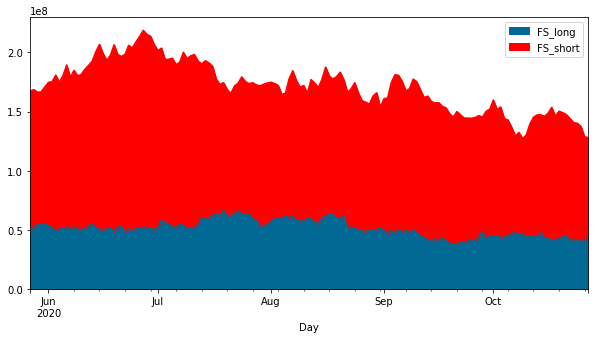

In [35]:
crude_otw.plot(kind='area', x='Day', y=['FS_long', 'FS_short'], figsize=(10,5), color=['#006994', 'red'])

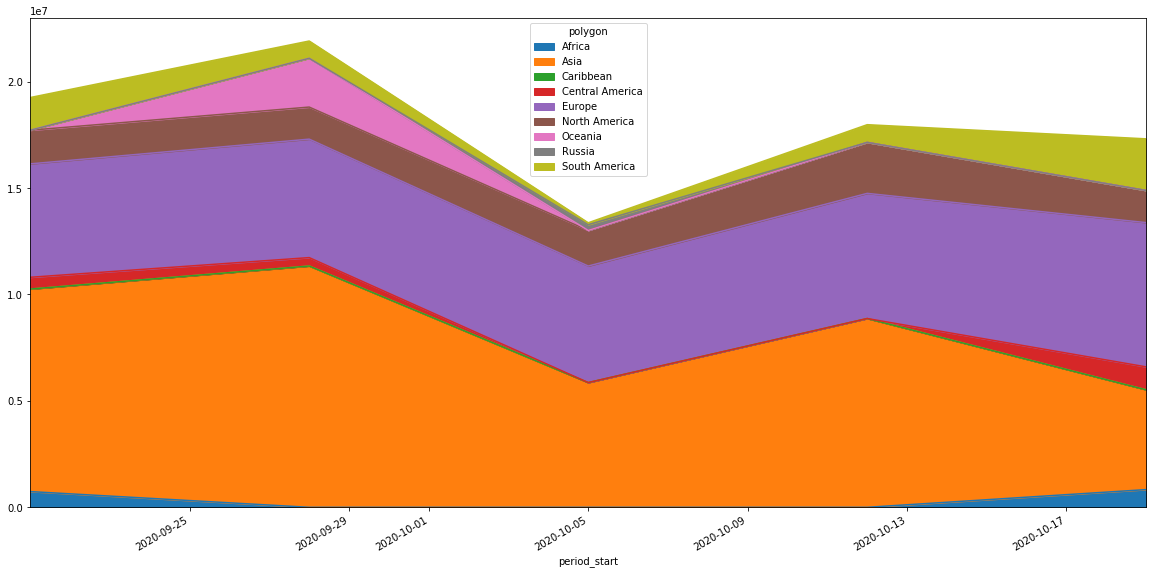

In [36]:
us_stacked.tail(5).plot(kind='area', figsize=(20,10))

## sql upload

In [37]:
padd_1_lights_imports.to_sql(
    name="padd_1_lights_imports_t",
    con=engine,
    schema="market_report_data",
    index=False,
    if_exists="replace",
)

waf_gasoline_imports.to_sql(
    name="waf_gasoline_imports_t",
    con=engine,
    schema="market_report_data",
    index=False,
    if_exists="replace",
)

meg_naphtha_exports.to_sql(
    name="meg_naphtha_exports_t",
    con=engine,
    schema="market_report_data",
    index=False,
    if_exists="replace",
)

russia_naphtha_exports.to_sql(
    name="russia_naphtha_exports_t",
    con=engine,
    schema="market_report_data",
    index=False,
    if_exists="replace",
)

ara_dist_imports.to_sql(
    name="ara_dist_imports_t",
    con=engine,
    schema="market_report_data",
    index=False,
    if_exists="replace",
)

padd3_dist_exports.to_sql(
    name="padd3_dist_exports_t",
    con=engine,
    schema="market_report_data",
    index=False,
    if_exists="replace",
)

baltic_dist_exports.to_sql(
    name="baltic_dist_exports_t",
    con=engine,
    schema="market_report_data",
    index=False,
    if_exists="replace",
)

india_dist_exports.to_sql(
    name="india_dist_exports_t",
    con=engine,
    schema="market_report_data",
    index=False,
    if_exists="replace",
)

baltic_black_sea_fo_exports.to_sql(
    name="baltic_black_sea_fo_exports_t",
    con=engine,
    schema="market_report_data",
    index=False,
    if_exists="replace",
)

baltic_black_sea_feedstock_exports.to_sql(
    name="baltic_black_sea_fo_feedstock_exports_t",
    con=engine,
    schema="market_report_data",
    index=False,
    if_exists="replace",
)

sing_fo_imports.to_sql(
    name="sing_fo_imports_t",
    con=engine,
    schema="market_report_data",
    index=False,
    if_exists="replace",
)

us_feedstock_imports.to_sql(
    name="us_feedstock_imports_t",
    con=engine,
    schema="market_report_data",
    index=False,
    if_exists="replace",
)

In [38]:
dist_otw.to_sql(
    name="dist_otw_t",
    con=engine,
    schema="market_report_data",
    index=False,
    if_exists="replace",
)

lights_otw.to_sql(
    name="lights_otw_t",
    con=engine,
    schema="market_report_data",
    index=False,
    if_exists="replace",
)

dirty_otw.to_sql(
    name="dirty_otw_t",
    con=engine,
    schema="market_report_data",
    index=False,
    if_exists="replace",
)

In [39]:
crude_otw.to_sql(
    name="crude_otw",
    con=engine,
    schema="market_report_data",
    index=False,
    if_exists="replace",
)

flows.to_sql(
    name="crude_flows",
    con=engine,
    schema="market_report_data",
    index=False,
    if_exists="replace",
)